In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statistics

from statsmodels.stats import inter_rater as irr
from typing import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
directory = "/Users/Millicent/Research/biomed-generation-analysis/biomed-generation-out"

In [4]:
results = {}

for path, _, files in os.walk(directory):
    for idx, file in enumerate(files):
        if file == ".DS_Store":
            continue
        else:
            final_path = os.path.join(path, file)
            data = []
            with open(final_path, "r") as f:
                for line in f:
                    data.append(json.loads(line))
            results[idx] = data

In [5]:
doc_idx = {}
for idx in range(10):
    doc_idx[idx + 1] = []

In [6]:
# Number of documents: should be 1 per person, times 4
for result in results:
    output = results[result][0]
    for question in output:
        doc_idx[question['data']['doc_idx']].append(question)

In [7]:
# Sanity check
for idx in doc_idx:
    assert len(doc_idx[idx]) == len(results)

In [8]:
# Aggregate headers for pandas
headers = ['doc_idx', 'completed_by', 'abstract', 'key_result', 'summary', 'plain_summary']
for idx in doc_idx:
    documents = doc_idx[idx]
    for document in documents:
        for doc in document['annotations'][0]['result']:
            headers.append(doc['from_name'])
        break
    break

In [9]:
df = pd.DataFrame(columns=headers)
df['completed_by'] = df['completed_by'].astype(int)

In [10]:
for idx in doc_idx:
    documents = doc_idx[idx]
    for document in documents:
        data = {
            'doc_idx' : idx,
            'completed_by' : int(document['annotations'][0]['completed_by']),
            'abstract' : document['data']['abstract'],
            'key_result' : document['data']['text'],
            'summary' : document['data']['summary'],
            'plain_summary' : document['data']['plain_summary']
        }
        doc = document['annotations'][0]['result']
        for doc in document['annotations'][0]['result']:
            try:
                data[doc['from_name']] = doc['value']['choices']
            except:
                data[doc['from_name']] = doc['value']
        df = df.append(data, ignore_index=True)

In [11]:
unwanted_headers = ['doc_idx', 'completed_by', 'abstract', 'key_result', 'summary', 'plain_summary']
headers_of_interest = [header for header in headers if header not in unwanted_headers]

In [12]:
likert_rating = ["Strongly disagree", "Disagree", "Agree", "Strongly agree"]
technical_terms_rating = ["None at all", "Only a few", "Mostly all", "All"]
omissions_rating = ["No ommision", "Minor omission(s)", "Major omission(s)"]
errors_rating = ["No errors", "Minor error", "Major error"]
likert_rating_dict = {s : idx for idx, s in enumerate(likert_rating)}
technical_terms_rating_dict = {s : idx for idx, s in enumerate(technical_terms_rating)}
omission_rating_dict = {s : idx for idx, s in enumerate(omissions_rating)}
errors_rating_dict = {s : idx for idx, s in enumerate(errors_rating)}

population_rating = [
    "The population is not mentioned (missing) in the model summary",
    "The population is mentioned, but described completely inaccurately",
    "The population is mentioned, but described somewhat inaccurately",
    "The population is mentioned, but somewhat underspecified",
    "The population is mentioned, and described accurately",
    "Not applicable (N/A)"
]
intervention_rating = [
    "The intervention is not mentioned (missing) in the model summary",
    "The intervention is mentioned, but described completely inaccurately",
    "The intervention is mentioned, but described somewhat inaccurately",
    "The intervention is mentioned, but somewhat underspecified",
    "The intervention is mentioned, and described accurately",
    "Not applicable (N/A)"
]
outcome_rating = [
    "The outcome is not mentioned (missing) in the model summary",
    "The outcome is mentioned, but described completely inaccurately",
    "The outcome is mentioned, but described somewhat inaccurately",
    "The outcome is mentioned, but somewhat underspecified",
    "The outcome is mentioned, and described accurately",
    "Not applicable (N/A)"
]

population_rating_plain = [
    "The population is not mentioned (missing) in the simplified model text",
    "The population is mentioned, but described completely inaccurately",
    "The population is mentioned, but described somewhat inaccurately",
    "The population is mentioned, but somewhat underspecified",
    "The population is mentioned, and described accurately",
    "Not applicable (N/A)"
]
intervention_rating_plain = [
    "The intervention is not mentioned (missing) in the simplified model text",
    "The intervention is mentioned, but described completely inaccurately",
    "The intervention is mentioned, but described somewhat inaccurately",
    "The intervention is mentioned, but somewhat underspecified",
    "The intervention is mentioned, and described accurately",
    "Not applicable (N/A)"
]
outcome_rating_plain = [
    "The outcome is not mentioned (missing) in the simplified model text",
    "The outcome is mentioned, but described completely inaccurately",
    "The outcome is mentioned, but described somewhat inaccurately",
    "The outcome is mentioned, but somewhat underspecified",
    "The outcome is mentioned, and described accurately",
    "Not applicable (N/A)"
]
population_rating_dict = {s : idx for idx, s in enumerate(population_rating)}
intervention_rating_dict = {s : idx for idx, s in enumerate(intervention_rating)}
outcome_rating_dict = {s : idx for idx, s in enumerate(outcome_rating)}

population_rating_plain_dict = {s : idx for idx, s in enumerate(population_rating_plain)}
intervention_rating_plain_dict = {s : idx for idx, s in enumerate(intervention_rating_plain)}
outcome_rating_plain_dict = {s : idx for idx, s in enumerate(outcome_rating_plain)}

In [13]:
rating_mapping = {
    'containsKeyResult' : likert_rating_dict,
    'population' : population_rating_dict,
    'intervention' : intervention_rating_dict,
    'outcome' : outcome_rating_dict,
    'omissions' : omission_rating_dict,
    'errors' : errors_rating_dict,
    'coherence' : likert_rating_dict,
    'usefulness' : likert_rating_dict,
    'containsKeyResult_plain' : likert_rating_dict,
    'population_plain' : population_rating_plain_dict,
    'intervention_plain' : intervention_rating_plain_dict,
    'outcome_plain' : outcome_rating_plain_dict,
    'omissions_plain' : omission_rating_dict,
    'errors_plain' : errors_rating_dict,
    'coherence_plain' : likert_rating_dict,
    'readability_plain' : likert_rating_dict,
    'substitution_plain' : technical_terms_rating_dict,
    'usefulness_plain' : likert_rating_dict,
}

In [14]:
headers_of_interest

['containsKeyResult',
 'population',
 'intervention',
 'outcome',
 'omissions',
 'errors',
 'coherence',
 'usefulness',
 'containsKeyResult_plain',
 'population_plain',
 'intervention_plain',
 'outcome_plain',
 'omissions_plain',
 'errors_plain',
 'coherence_plain',
 'readability_plain',
 'substitution_plain',
 'usefulness_plain']

In [18]:
# Functions for analysis
def get_by_doc_idx(df, id: int) -> pd.DataFrame:
    return df.loc[df['doc_idx'] == id]

def get_distribution(df: pd.DataFrame, column: str) -> Union[List[str], List[str], List[str]]:
    df_curr = df.loc[:, column]
    ratings = rating_mapping[column]
    labels = df_curr.to_numpy()
    labels = [label[0] for label in labels]
    distribution = np.zeros(len(ratings))
    for label in labels:
        idx = ratings[label]
        distribution[idx] += 1
    return distribution, labels, ratings

# SHOULD BE SUBJECT/SAMPLE x RATER AS THE RETURN RESULT -- ACROSS ONE TYPE OF COLUMN
# Assigning a # means the assigned category
# From https://stackoverflow.com/a/70117023
def get_sample_by_choice(df: pd.DataFrame, column: str) -> List[str]:
    ratings = rating_mapping[column]
    max_doc_idx = 10
    output = []
    for idx in range(max_doc_idx):
        docs = get_by_doc_idx(df, idx + 1)
        # Get the column we want now for this specific doc_idx (doc 1, doc 2, doc 3, etc)
        df_curr = docs.loc[:, column]
        labels = df_curr.to_numpy()
        labels = [label[0] for label in labels]
        distribution = np.zeros(len(df_curr))
        for i, label in enumerate(labels):
            distribution[i] = ratings[label]
        output.append(distribution)

    return np.array(output)

def plot_distributions_and_all(df: pd.DataFrame, columns: List[str]) -> None:
    for idx, column in enumerate(columns):
        distribution, _, ratings = get_distribution(df, column)
        variance, mean, stddev = get_statistics(distribution)
        kappa = get_fleiss_kappa(df, column)
        print(f"Statistics for {column}:\n    Variance: {variance}\n    Mean: {mean}\n    Std Dev: {stddev}\n    Kappa: {kappa}")
        # fig, axs = plt.subplots(1, 18, figsize=(15,15))
        x = np.arange(len(distribution))
        y = np.arange(int(max(distribution)))
        # print("Here's x:", x)
        # print("Here's y:", y)
        # x_index = idx % 9
        # y_index = int(idx // 9)
        ratings_as_labels = [key for key in ratings]
        plt.bar(ratings_as_labels, distribution)
        # plt.xticks(labels)
        plt.xticks(rotation = 90)
        plt.yticks(y)
        plt.title(column)
        plt.xlabel("Agreement Type")
        plt.ylabel("Frequency")

        # print("Here's x_index:", x_index)
        # print("Here's y_index:", y_index)
        # print()
        # axs[x_index, y_index].set_xticks(x)
        # axs[x_index, y_index].set_yticks(y)
        # axs[x_index, y_index].set_xticklabels("Agreement Type")
        # axs[x_index, y_index].set_yticklabels("Frequency")
        # axs[x_index, y_index].bar(x, distribution)
        # axs[x_index, y_index].title(column)
        # axs[idx].set_xticks(x)
        # axs[idx].set_yticks(y)
        # axs[idx].set_xticklabels("Agreement Type")
        # axs[idx].set_yticklabels("Frequency")
        # axs[idx].bar(x, distribution)
        # axs[idx].title(column)
        plt.show()

def get_fleiss_kappa(df: pd.DataFrame, column: List[str]):
    """
    Some information on kappas:
    Null Hypothesis Kappa = 0	Agreement is due to chance
    0.01-0.020	Slight agreement
    0.21-0.40	Fair Agreement
    0.41-0.60	Moderate Agreement
    0.61-0.80	Substantial Agreement
    0.81-1.00	Almost Perfect Agreement
    Negative (Kappa<0)	Agreement less than that expected by chance
    """
    # Should be subject/sample x rater
    distribution = get_sample_by_choice(df, column)
    # Should be subject/sample x cat counts
    aggregated = irr.aggregate_raters(distribution)
    
    # Debug prints
    # print("Here's distribution:", distribution)
    # print("Here's aggregated:", aggregated)
    return irr.fleiss_kappa(aggregated[0], method='fleiss')


def get_statistics(distribution: List[int]) -> Union[float, float]:
    values_per_label = []
    for idx, d in enumerate(distribution):
        l = [idx for _ in range(int(d))]
        values_per_label.extend(l)

    return statistics.variance(values_per_label), \
            statistics.mean(values_per_label), \
            statistics.stdev(values_per_label)



In [19]:
# for header in headers_of_interest:
#     print("Header:", header)
#     print(get_fleiss_kappa(df, header))

Statistics for containsKeyResult:
    Variance: 0.9429487179487179
    Mean: 1.925
    Std Dev: 0.9710554659486336
   Kappa: 0.05269390171699226


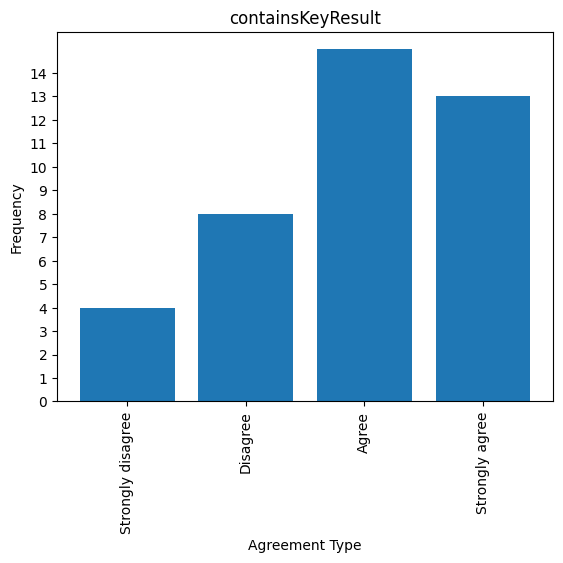

Statistics for population:
    Variance: 2.5993589743589745
    Mean: 2.625
    Std Dev: 1.6122527637932504
   Kappa: 0.3296089385474859


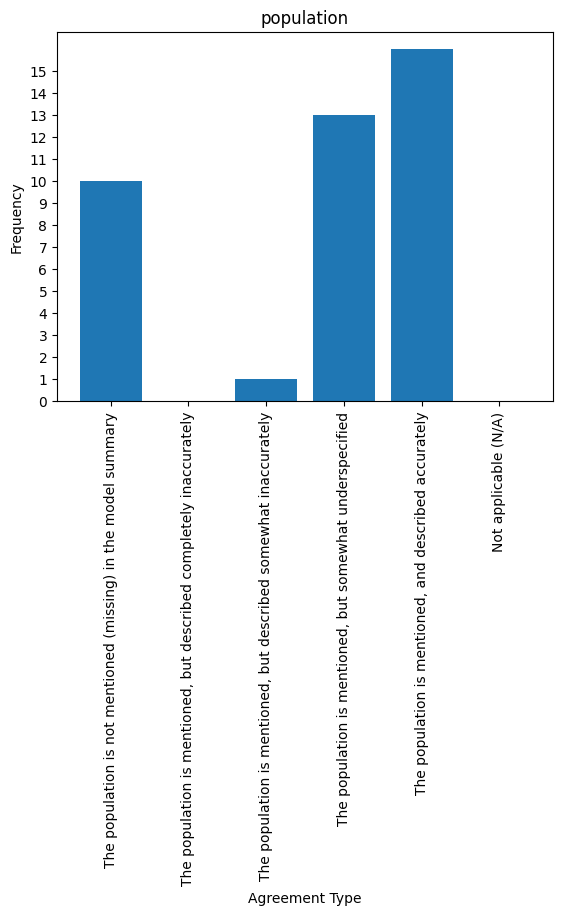

Statistics for intervention:
    Variance: 0.7589743589743589
    Mean: 3.4
    Std Dev: 0.8711913446392583
   Kappa: 0.099099099099099


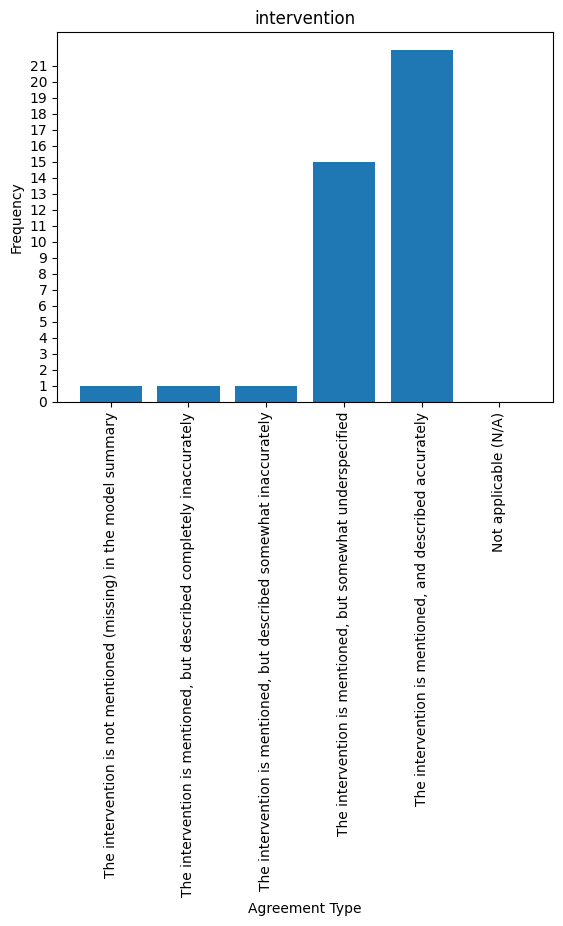

Statistics for outcome:
    Variance: 0.742948717948718
    Mean: 3.225
    Std Dev: 0.8619447302169194
   Kappa: 0.11646586345381535


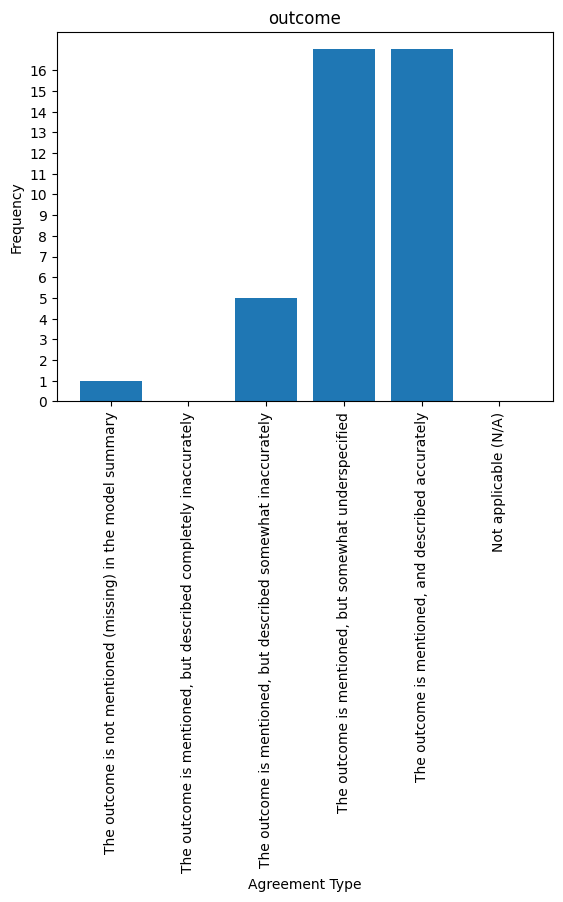

Statistics for omissions:
    Variance: 0.5538461538461539
    Mean: 1.1
    Std Dev: 0.7442084075352507
   Kappa: 0.1163092917478881


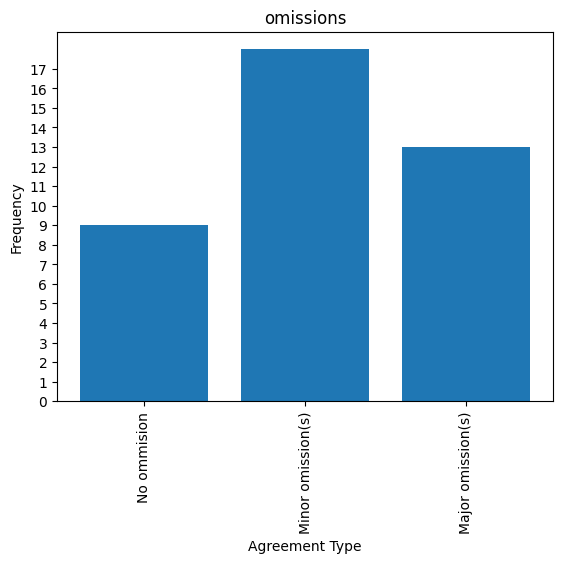

Statistics for errors:
    Variance: 0.34615384615384615
    Mean: 0.25
    Std Dev: 0.5883484054145521
   Kappa: -0.04252400548696814


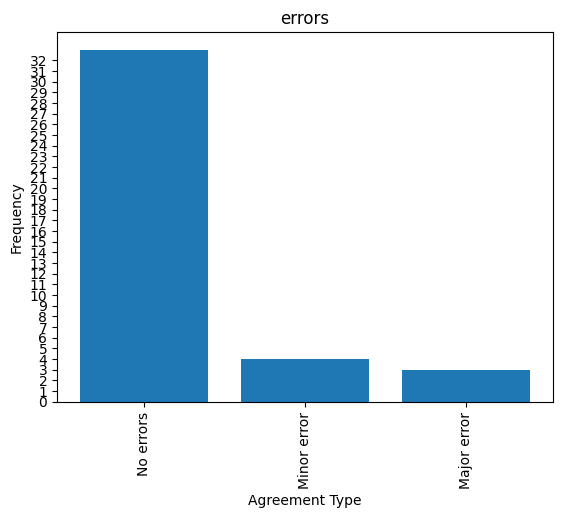

Statistics for coherence:
    Variance: 0.2814102564102564
    Mean: 2.775
    Std Dev: 0.5304811555656397
   Kappa: 0.004149377593360907


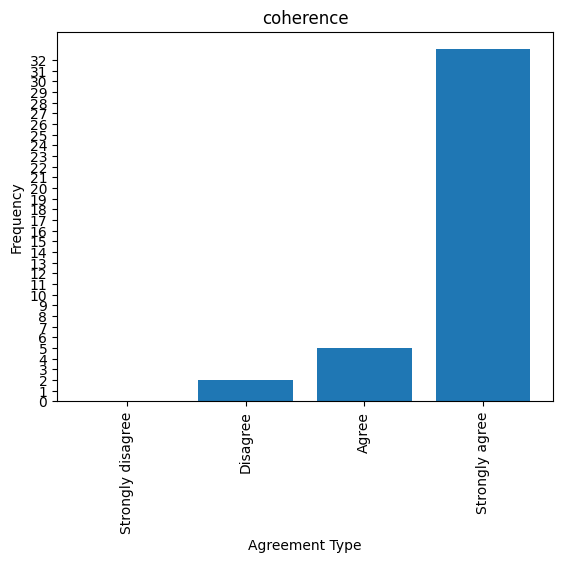

Statistics for usefulness:
    Variance: 0.6352564102564102
    Mean: 2.075
    Std Dev: 0.7970297423913427
   Kappa: 0.129878438899552


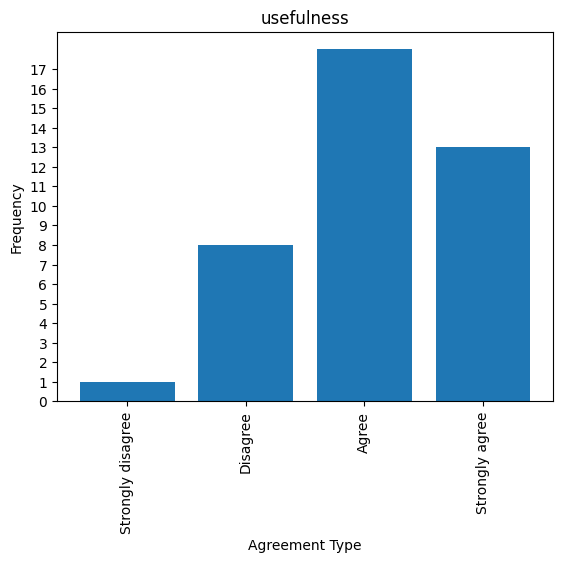

Statistics for containsKeyResult_plain:
    Variance: 0.8967948717948718
    Mean: 1.775
    Std Dev: 0.9469925405170158
   Kappa: 0.18022905364677516


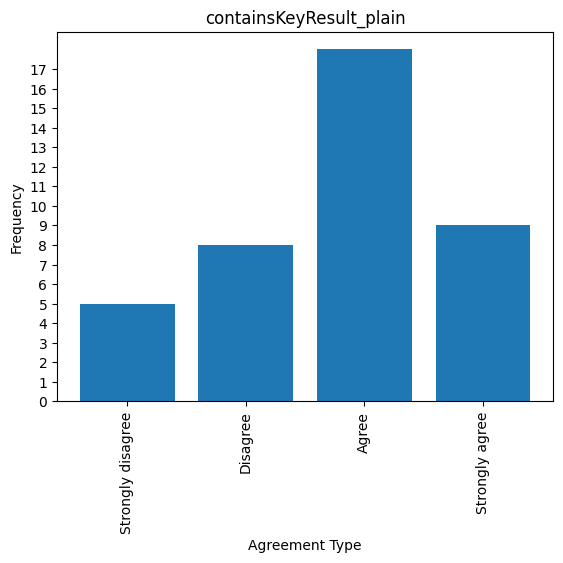

Statistics for population_plain:
    Variance: 3.023076923076923
    Mean: 2.45
    Std Dev: 1.7386997794550165
   Kappa: 0.26199261992619943


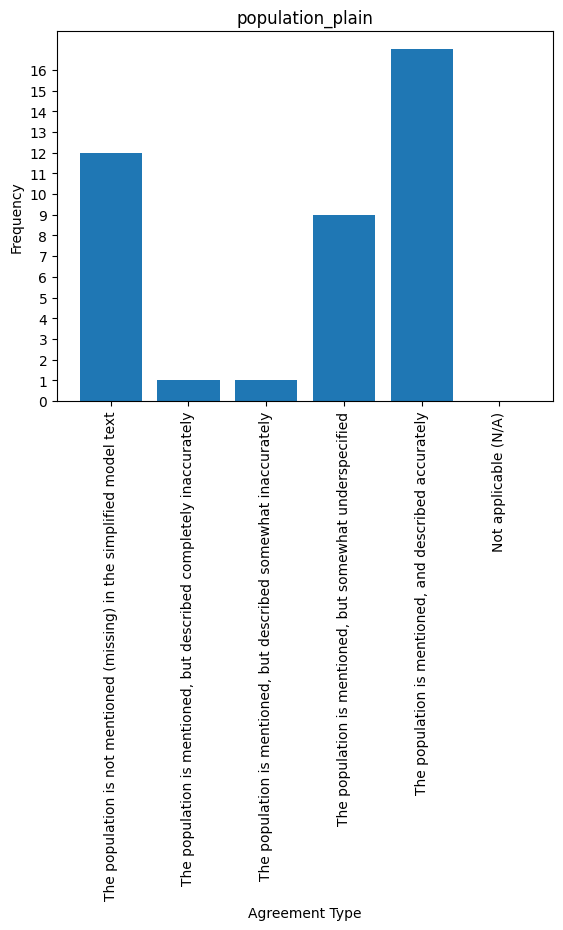

Statistics for intervention_plain:
    Variance: 1.0506410256410257
    Mean: 3.225
    Std Dev: 1.025007817356056
   Kappa: 0.23340177960301164


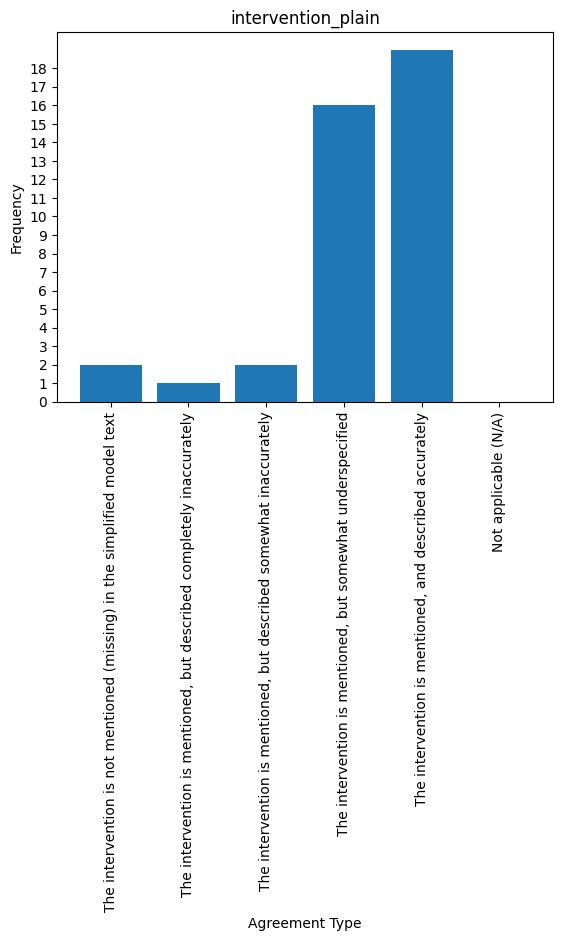

Statistics for outcome_plain:
    Variance: 0.625
    Mean: 3.125
    Std Dev: 0.7905694150420949
   Kappa: 0.46666666666666645


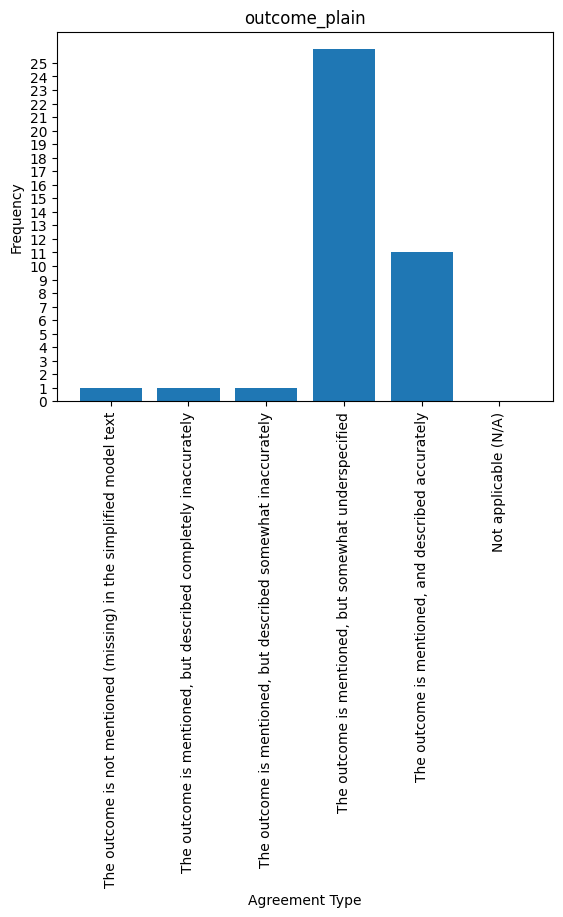

Statistics for omissions_plain:
    Variance: 0.6762820512820513
    Mean: 1.125
    Std Dev: 0.8223636976922384
   Kappa: 0.19038583175205562


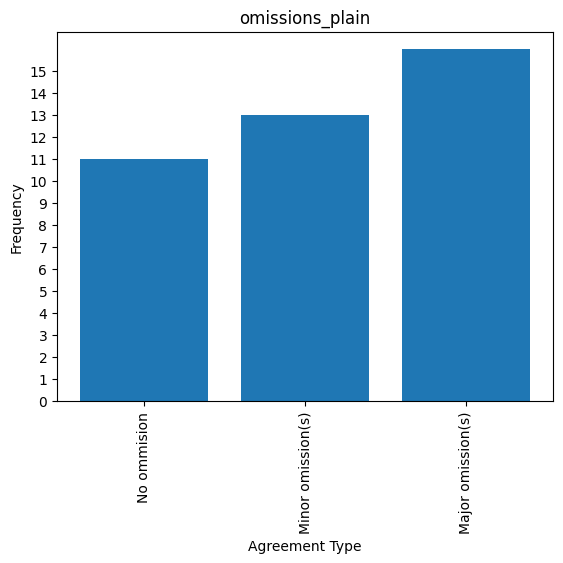

Statistics for errors_plain:
    Variance: 0.28461538461538466
    Mean: 0.15
    Std Dev: 0.533493565673837
   Kappa: -0.0810810810810818


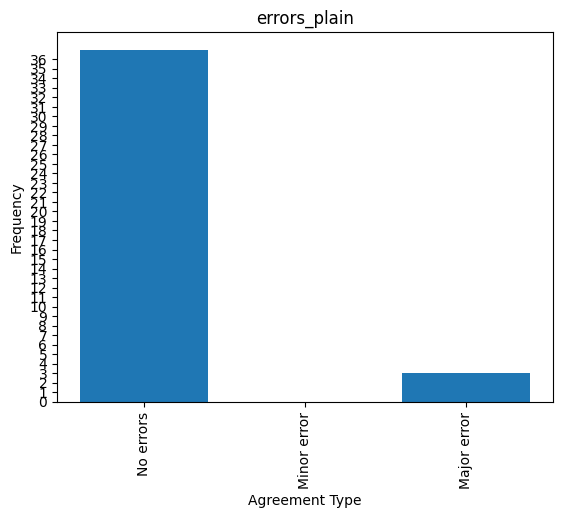

Statistics for coherence_plain:
    Variance: 0.21538461538461537
    Mean: 2.8
    Std Dev: 0.4640954808922571
   Kappa: -0.06891701828410639


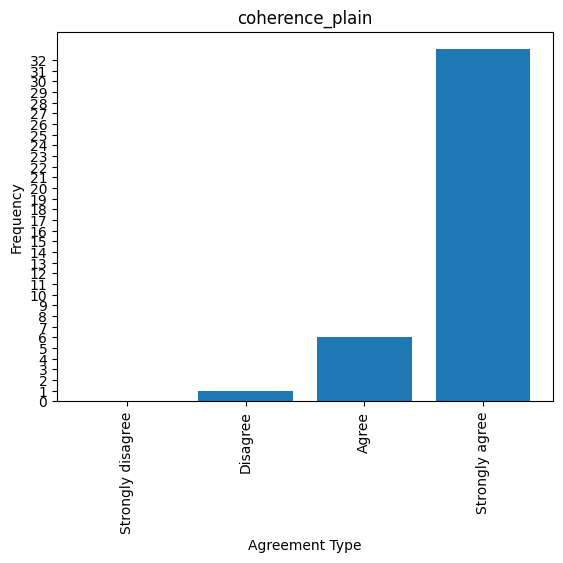

Statistics for readability_plain:
    Variance: 0.4512820512820513
    Mean: 2.6
    Std Dev: 0.6717752982077052
   Kappa: 0.09420289855072486


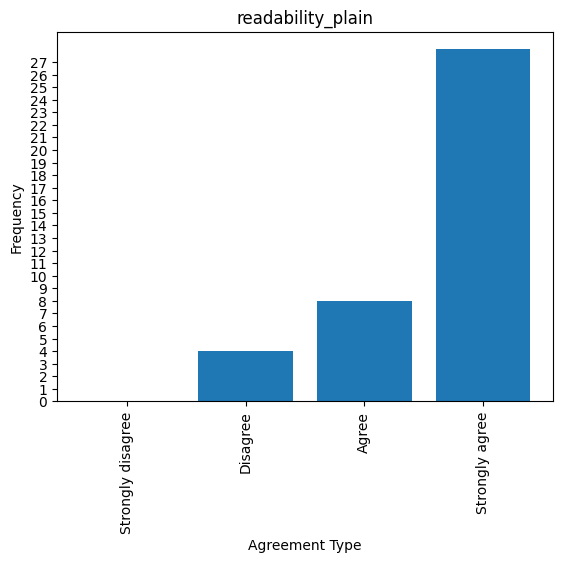

Statistics for substitution_plain:
    Variance: 0.7051282051282052
    Mean: 2.25
    Std Dev: 0.8397191227596316
   Kappa: 0.17333333333333326


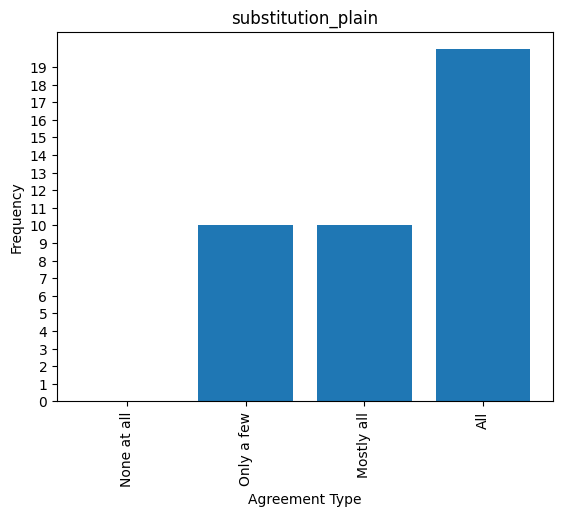

Statistics for usefulness_plain:
    Variance: 0.4076923076923077
    Mean: 2.05
    Std Dev: 0.6385078759829887
   Kappa: 0.021097046413501814


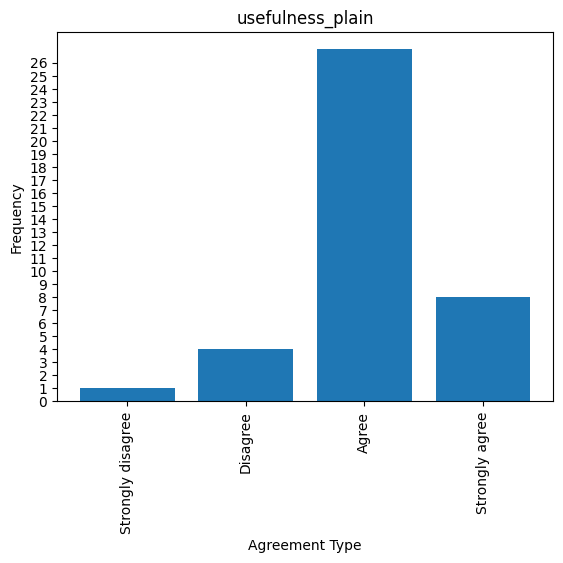

In [20]:
plot_distributions_and_all(df, headers_of_interest)